In [16]:
from roboflow import Roboflow
import supervision as sv
import cv2
import numpy as np  
from decimal import Decimal, ROUND_HALF_UP  
import os
import json

In [3]:
rf = Roboflow(api_key="Vw3xc06UBFiaXmZDTNJx")
project = rf.workspace().project("go-positions")
model = project.version(4).model

loading Roboflow workspace...
loading Roboflow project...


In [14]:
result = model.predict("r1.jpg", confidence=45, overlap=50).json()

labels = [item["class"] for item in result["predictions"]]

detections = sv.Detections.from_inference(result)

label_annotator = sv.LabelAnnotator()
bounding_box_annotator = sv.BoxAnnotator()

image = cv2.imread("r1.jpg")

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)



SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


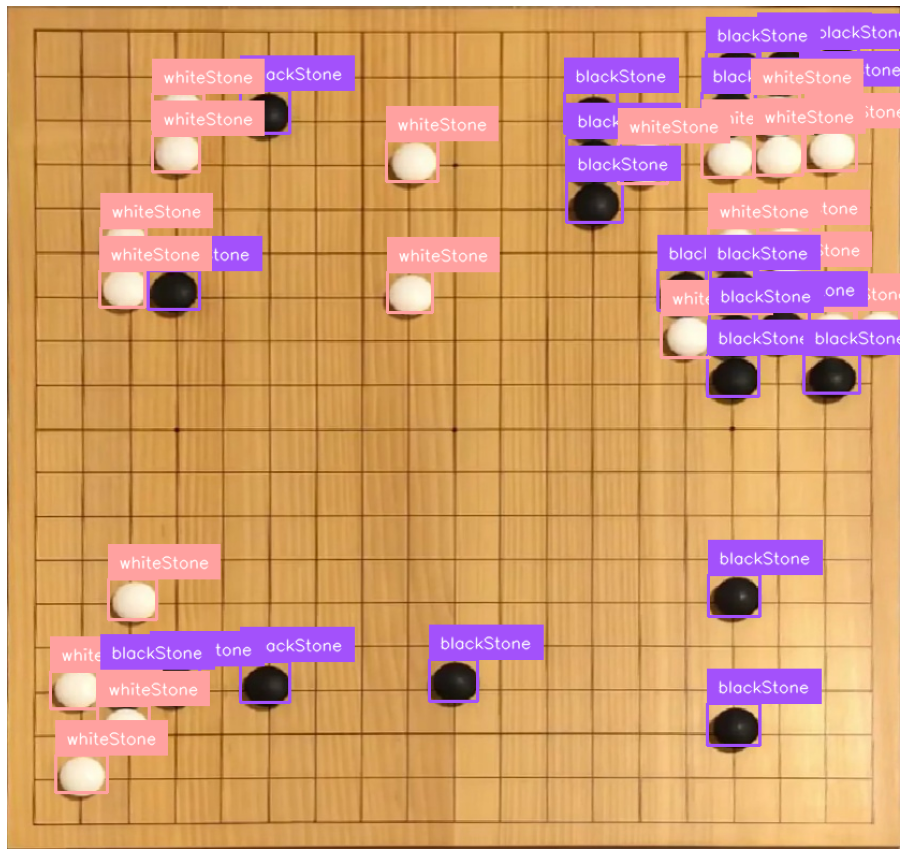

In [15]:
sv.plot_image(image=annotated_image, size=(16, 16))

In [51]:
for i in result:
    print(result[i])

[{'x': 617, 'y': 354, 'width': 518, 'height': 507, 'confidence': 0.9311633110046387, 'class': 'grid', 'class_id': 1, 'detection_id': 'd34386e8-5178-4c01-93f0-a7831abc8622', 'image_path': './keyframes/0001.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 454, 'y': 192, 'width': 24, 'height': 27, 'confidence': 0.8364561796188354, 'class': 'whiteStone', 'class_id': 2, 'detection_id': 'b7634a1b-e4ea-4645-ab1d-98675fbe427f', 'image_path': './keyframes/0001.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 508, 'y': 164, 'width': 24, 'height': 24, 'confidence': 0.8309333324432373, 'class': 'whiteStone', 'class_id': 2, 'detection_id': 'a95985e2-31b2-4310-8d07-7287742d2010', 'image_path': './keyframes/0001.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 812, 'y': 495, 'width': 24, 'height': 25, 'confidence': 0.8302095532417297, 'class': 'whiteStone', 'class_id': 2, 'detection_id': '6cb8f540-37f0-4d06-87fb-9423a8aee4e5', 'image_path': './keyframes/0001.jpg', 'prediction_typ

In [28]:
def findClip(image):
    # 将图像转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 应用高斯模糊
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 边缘检测
    edges = cv2.Canny(blurred, 50, 150)

    # 形态学操作，连接断开的边缘
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=5)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(edges, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # 查找轮廓
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 假设最大的轮廓是棋盘
    contour = max(contours, key=cv2.contourArea)

    cv2.imshow("Cropped Chessboard", edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 近似多边形
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # 如果近似多边形的顶点数为4，认为找到了棋盘
    if len(approx) == 4:
        # 获取顶点
        pts = approx.reshape(4, 2)
        
        # 对顶点进行排序，顺序为：[top-left, top-right, bottom-right, bottom-left]
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        return rect
      
    else:
        print("棋盘检测失败，未能找到棋盘的四个顶点。")

In [29]:
def clipImg(rect, image):
    # 计算变换后的宽度和高度
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # 目标矩形的顶点
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # 计算透视变换矩阵
    M = cv2.getPerspectiveTransform(rect, dst)

    # 应用透视变换
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

In [30]:
def extract_key_frames(video_path, threshold=30, interval=30, output_folder='./keyframes/'):  
    # 确保输出文件夹存在  
    if not os.path.exists(output_folder):  
        os.makedirs(output_folder)  
  
    # 打开视频文件  
    cap = cv2.VideoCapture(video_path)  
  
    # 读取第一帧  
    ret, prev_frame = cap.read()  
    if not ret:  
        print("Error: Cannot read video file.")  
        return  
    
    # 存储第一帧
    frame_count = 1  
    clipArea = findClip(prev_frame)
    clipPrev_frame = clipImg(clipArea, prev_frame)
    filename = f"{output_folder}/{frame_count:04d}.jpg"  
    cv2.imwrite(filename, clipPrev_frame)
    #cv2.imwrite("r2.jpg", prev_frame)

    while cap.isOpened():  
        ret, frame = cap.read()  
        if not ret:  
            break  
            
        frame_count += 1 

        if frame_count % interval == 0:
            
            # 计算均方误差（MSE）  
            clipframe = clipImg(clipArea, frame)
            mse = np.mean((clipframe.astype("float") - clipPrev_frame.astype("float")) ** 2, axis=(0,1))  
            mse_value = np.mean(mse)  # 计算RGB三个通道的MSE平均值 
            print(mse_value)
            
    
            # 如果差异超过阈值，保存这一帧  
            if mse_value > threshold:  
                filename = f"{output_folder}/{frame_count:04d}.jpg"  
                cv2.imwrite(filename, clipframe)  
                print(f"Mean Squared Error (MSE): {mse_value}") 
                print(f"Saved keyframe: {filename}")  
    
            # 更新前一帧  
            clipPrev_frame = clipframe
  
    # 释放资源  
    cap.release()  
    cv2.destroyAllWindows()  

In [17]:
#计算棋盘间隔
def getMargin(result):
    img_width = result["image"]["width"]
    img_height = result["image"]["height"]
    board_len = (float(img_height) + float(img_width))/2
    return board_len/38


In [18]:
#棋盘行位转换
def row_pos_trans(pos):
    alphalst = ["A","B","C","D","E","F","G","H","J","K","L","M","N","O","P","Q","R","S","T"]
    numlst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]  
    if pos in numlst:
        idx = numlst.index(pos)
        return(alphalst[idx])
    return pos

In [19]:
#计算棋子相对棋盘位置
def get_stone(prediction, Margin):
    x = prediction["x"]
    y = prediction["y"]
    n1 = Decimal(x / Margin)
    n2 = Decimal(y / Margin)
    x = n1.quantize(Decimal('1'), rounding=ROUND_HALF_UP) 
    y = n2.quantize(Decimal('1'), rounding=ROUND_HALF_UP)
    n3 = Decimal((x+1)/2)
    tpx = n3.quantize(Decimal('1'), rounding=ROUND_HALF_UP)
    s1 = row_pos_trans(tpx)
    s2 = 20 - int((y+1)/2)
    Class = prediction["class"]
    info = [s1,s2,Class]
    
    return(info)

In [20]:
#单步信息写入字典
def WriteInDic(Bp, Wp, n, t):
    data = {  
        "step": n, 
        "black": Bp,  
        "white": Wp,
        "time": t  
    } 
    return data 

In [21]:
#写入json文件
def WriteInJson(lst, write_path):
    json_string = json.dumps(lst)
    with open(write_path, 'a', encoding='utf-8') as file:  
        file.write(json_string)

In [22]:
#获取棋盘所有棋子位置信息
def goPositionPredict(img_path, step, t):
    Result = model.predict(img_path, confidence=45, overlap=50).json()
    Margin = getMargin(Result)
    black_pos = []
    white_pos0 = []
    white_pos = []
    

    for i in Result["predictions"]:
        tmp = get_stone(i,Margin)
        if(tmp[2] == 'blackStone'):
            black_pos.append(tmp[0]+str(tmp[1]))
        if(tmp[2] == 'whiteStone'):
            white_pos0.append(tmp[0]+str(tmp[1]))
    
    for i in white_pos0:
        if i not in black_pos:
            white_pos.append(i)
    
    return WriteInDic(black_pos,white_pos,step,t)
    

    
    

In [23]:
folder_path = "./keyframes"
write_path = "goList.json"
video_path = "./video/test3.mp4"

In [ ]:
#Video extraction
extract_key_frames(video_path)

In [27]:
#Main
dic_list = []
for root, dirs, files in os.walk(folder_path):
    step = 1
    for name in files:
        img_path = os.path.join(root, name)
        dic_list.append(goPositionPredict(img_path, step, name[0:4]))
        
        step = step + 1

WriteInJson(dic_list, write_path)